## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?
-------------------

### Import Boston Housing dataset using Keras

In [76]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

### Normalize the data

Neural networks are able to converge with data that hasn't been normalized. But, normalizing the data can cause the model to converge more quickly. Normalization is more important for traditional statistical models, and very important for distance-based clustering algorithms.

In [77]:
import numpy as np

X_train = (X_train / np.amax(X_train, axis=0)).astype('float32')
X_test = (X_test / np.amax(X_test, axis=0)).astype('float32')

y_train = (y_train / np.amax(y_train, axis=0)).astype('float32')
y_test = (y_test / np.amax(y_train, axis=0)).astype('float32')

In [78]:
X_train.shape

(404, 13)

### Import the type of model and layers that you will need from Keras

In [79]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Instantiate a model object

In [80]:
model = Sequential()

# Input layer + hidden layer
model.add(Dense(10, input_dim=13, activation='sigmoid'))
model.add(Dense(10, activation='relu'))
# Output layer (no activation for output layer in regression problems)
model.add(Dense(1))

### Compile the model

In [81]:
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['mean_squared_error', 'accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


### Fit your model and report its accuracy in terms of Mean Squared Error

In [82]:
history = model.fit(X_train, y_train, epochs=100, verbose=0)
scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

102/102 [==============================] - 0s 316us/sample - loss: 594.9763 - mean_squared_error: 594.9763 - acc: 0.0000e+00
mean_squared_error: 594.976318359375


### Graph the model's loss or train/validation accuracies by epoch

In [83]:
# pandas is needed for altair to read the history data
import altair.vegalite.v2 as alt
import pandas as pd

In [84]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.head()

,loss,mean_squared_error,acc,epoch
0,0.449899,0.449899,0.0,0
1,0.061148,0.061148,0.0,1
2,0.036428,0.036428,0.0,2
3,0.034205,0.034205,0.0,3
4,0.033974,0.033974,0.0,4


In [85]:
history_df.describe()

,loss,mean_squared_error,acc,epoch
count,100.000000,100.000000,100.000000,100.000000
mean,0.036053,0.036053,0.000965,49.500000
std,0.041932,0.041932,0.001213,29.011492
min,0.029281,0.029281,0.000000,0.000000
25%,0.030363,0.030363,0.000000,24.750000
50%,0.031479,0.031479,0.000000,49.500000
75%,0.032788,0.032788,0.002475,74.250000
max,0.449899,0.449899,0.002475,99.000000


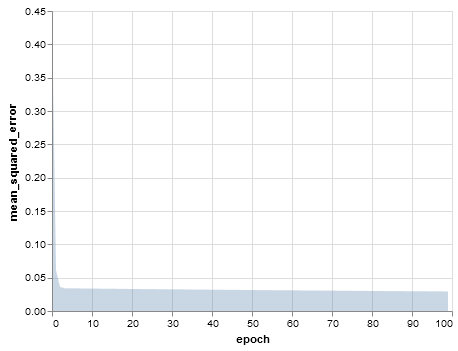

In [86]:
alt.Chart(history_df).mark_area(opacity=0.3).encode(
    x='epoch',
    y='mean_squared_error'
)

### Run this same data through a linear regression model. Which achieves higher accuracy?

Since this is not a classification task, the accuracy metric cannot be used for this estimator. Instead, a metric such as `'neg_mean_squared_error'` can be used.

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression(normalize=True, n_jobs=-1)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [89]:
reg_neg_mae = abs(cross_val_score(reg, X_test, y_test, cv=5, scoring='neg_mean_squared_error'))
reg_mae = reg_neg_mae.mean()
print("Neural network MSE: ", scores[1])
print("OLS/Linear regression MSE: ", reg_mae)

Neural network MSE:  594.9763
OLS/Linear regression MSE:  21.814922904968263


### Perform feature engineering and see how that affects your neural network model

In [129]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

boston_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)])
boston_y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)])
boston_df.shape, boston_y.shape
#boston_df.head()

((506, 13), (506, 1))

In [131]:
boston_df.corr()
#Create interaction terms for these pairs w/ high corr. coefs:
# 17, 24, 27, 47, 46, 67, 89
boston_df[17] = boston_df[1] * boston_df[7]
boston_df[24] = boston_df[2] * boston_df[4]
boston_df[27] = boston_df[2] * boston_df[7]
boston_df[47] = boston_df[4] * boston_df[7]
boston_df[46] = boston_df[4] * boston_df[6]
boston_df[67] = boston_df[6] * boston_df[7]
boston_df[89] = boston_df[8] * boston_df[9]

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(boston_df, boston_y, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train.shape

(404, 20)

In [133]:
# Reinitialize model with new input dimensions
model = Sequential()

# Input layer + hidden layer
model.add(Dense(10, input_dim=20, activation='sigmoid'))
model.add(Dense(10, activation='relu'))
# Output layer (no activation for output layer in regression problems)
model.add(Dense(1))

# Recompile the model
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['mean_squared_error', 'accuracy'])

# Fit and score model
history = model.fit(X_train, y_train, epochs=100, verbose=0)
scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

102/102 [==============================] - 0s 350us/sample - loss: 91.5482 - mean_squared_error: 91.5482 - acc: 0.0000e+00
mean_squared_error: 91.54815673828125


## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [ ]:
##### Your Code Here #####

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.